In [1]:
%%capture
!pip install networkx torch torch-geometric seaborn

In [2]:
import numpy as np
import json

import networkx as nx
import seaborn as sns

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_networkx
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [3]:
#++++++++++++++++++++++++++++++
# Data loading
#++++++++++++++++++++++++++++++

# Load node labels
labels_file = "tasks/data/git_targets.txt"
nodes = []
node_labels = {}  # Dictionary with nodes as key and corresponding label as value
with open(labels_file, "r") as file:
    next(file)    # Skip header
    for line in file:
        node, _, label = map(str, line.strip().split(","))
        node_labels[node] = int(label)
        nodes.append(node)

# Load edges
edges_file = "tasks/data/git_edges.txt"
edges = []
with open(edges_file, "r") as file:
    next(file)
    for line in file:
        node1, node2 = map(str, line.strip().split(","))
        edges.append((node1, node2))

In [4]:
# Load features
features_file = "tasks/data/git_features.json"
features_dict = {}
with open(features_file, "r") as file:
    features_dict = json.load(file)

# One-hot encoding for the features
num_nodes = len(features_dict)
all_features_list=[]
for node in range(num_nodes):
    all_features_list += features_dict[str(node)]

max_feature = max(all_features_list)

encoded_features_dict={}
for node in range(num_nodes):
    node = str(node)
    encoded_features = np.array([0] * (max_feature + 1))
    node_features = features_dict[str(node)]
    encoded_features[node_features] = 1
    encoded_features_dict[node] = list(encoded_features)

In [5]:
#++++++++++++++++++++++++++++++
# Graph creation
#++++++++++++++++++++++++++++++

# The dataset can be represented by a homogeneous graph: a single type of node, a single type of edge.
# Ingredients: nodes and connections between nodes. In addition, labels for the node classification task.
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
nx.set_node_attributes(graph, node_labels, 'label')

In [6]:
#++++++++++++++++++++++++++++++
# Dataset examination
#++++++++++++++++++++++++++++++

# Graph statistics
print("Number of nodes (graph order):", graph.number_of_nodes())
print("Number of edges (graph volume):", graph.number_of_edges())

# Distribution of node labels - necessary investigation for the training phase of the machine learning model
unique_labels = set(node_labels.values())
label_counts = {label: list(node_labels.values()).count(label) for label in unique_labels}  # Dictionary with label as key and number of nodes as value
total_nodes = len(graph.nodes)
label_ratios = {label: count / total_nodes for label, count in label_counts.items()} # Dictionary with label as key and ratio of nodes wrt total as value
print("\nNode label distribution:")
for label, count in label_counts.items():
    print(f"Label {label}: Count {count}, Ratio {label_ratios[label]:.4f}")

# Weights calculator
label_weights = {label: 1 / ratio for label, ratio in label_ratios.items()}
min_weight = min(label_weights.values()) # Finds the minimum weight so that it can be set to 1
normalized_label_weights = {label: weight / min_weight for label, weight in label_weights.items()}
print("\nNode label normalized weights:")
for label, weight in normalized_label_weights.items():
    print(f"Label {label}: Weight {weight:.4f}")

# Creating a list of weights for the machine learning model
weights_list = []
for label in sorted(normalized_label_weights.keys()):
    weights_list.append(normalized_label_weights[label])
print("\nWeights List:")
print(weights_list)

# Connected components in the graph
components = list(nx.connected_components(graph))
print("\nNumber of Connected Components:", len(components))

# Density
density = nx.density(graph)
print("\nGraph Density (scale 0-1): {:.4f}\n".format(density))

Number of nodes (graph order): 37700
Number of edges (graph volume): 289003

Node label distribution:
Label 0: Count 27961, Ratio 0.7417
Label 1: Count 9739, Ratio 0.2583

Node label normalized weights:
Label 0: Weight 1.0000
Label 1: Weight 2.8710

Weights List:
[1.0, 2.8710339870623267]

Number of Connected Components: 1

Graph Density (scale 0-1): 0.0004



## **Dataset Examination: Graph Properties Analysis**

The first step is analysing the dataset through its graph representation.


### Basic properties

Having 37,700 nodes and 289,003 edges, both graph order and graph size can be considered large.

The distribution of node labels highlights an imbalance in the dataset: the majority of nodes (74.17%) are labelled by 0 (*_"web developers"_*) while the rest are labelled by 1 (_"machine learning developers"_). The classification task will therefore be **binary**. This difference in the proportion must be accounted for during the classifier training phase, via the implementation of class weights.


### Connectedness and density

The observation of a single connected component implies a fully connected graph, where every node is reachable from every other node.

The density is the proportion of existing edges relative to the maximum possible number of edges the graph can have, ranging from 0 to 1. It can be seen as a way to infer how closely the nodes are connected in the network, at a global level.
For this graph, the density is of the order ~0.0001, so the arrangement of connections can be considered sparse.


In [7]:
#++++++++++++++++++++++++++++++
# Communities detection
#++++++++++++++++++++++++++++++

# This code block is just illustrative on how to generate the visualization of the graph with the different commmunities highlighted, such as the figures in the README. It is disabled by default due to being computationally expensive; To run it, set <run_cell> to True.
# Note: by default, a subset (~1/5th of the dataset) will be plotted; to visualize the communities of the whole graph, set subset_visualization to False. The default visualization is the subgraph of all machine learning developers.
# Note: module <community> might clash with pre-installed libraries. see: https://stackoverflow.com/questions/53087066/how-to-use-the-communities-module-python-louvain-in-networkx-2-2


run_cell = False
subset_visualization = True

if run_cell == True:
    import community
    !pip install python-louvain

    # Community detection through Louvain method
    partition = community.best_partition(graph)
    num_communities = len(set(partition.values()))
    print("Total number of Communities: {}".format(num_communities))

    # Community visualization
    if subset_visualization == True:    # Visualize a subset: all the nodes labelled by "1"
        nodes_of_interest = [node for node, label in node_labels.items() if label == 1]
        graph = graph.subgraph(nodes_of_interest)
    pos = nx.spring_layout(graph)   # Spring layout for visualization
    node_colors = [partition[node] for node in graph.nodes()]   # Get node colors based on communities
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, cmap=plt.cm.hsv, node_size=3)
    nx.draw_networkx_edges(graph, pos, alpha=0.05)
    plt.show()

### Community detection

Graphs can present local areas of higher density even if globally they are sparsely connected.
If a (appropriately large) subgroup of nodes has a **relatively** higher density compared to the surroundings, it is called a _community_.
Community detection algorithms have the task to find subgraphs where the nodes are more connected to each other than to the neighborhood.

This can aid the visualization of a graph, where nodes belonging to the given community are colored in the same way.

Aleatory factors play an important role when dealing with a community-finding algorithm, so the number of *detected* communities is subject to statistical fluctuation. For the GitHub dataset, it is around ~**35-39**.

In [8]:
#++++++++++++++++++++++++++++++
# Clustering coefficients and node degree distribution
#++++++++++++++++++++++++++++++

def get_clustering_coefficient(label_value, clustering_coefficients_dict):
    """
    - Selects the clustering coefficients belonging to a given class

    Arguments:
    ----------
    label_value (int)
        The class for which to select the clustering coefficients.

    clustering_coefficients_dict (dict)
        A dictionary containing nodes as keys and corresponding clustering coefficients as values.

    Returns:
    ----------
    clustering_coefficients_given_label (list)
        A list of clustering coefficients for nodes in the specified class.
    """
    label_nodes = [node for node, label in node_labels.items() if label == label_value]
    clustering_coefficients_given_label = [clustering_coefficients_dict[node] for node in label_nodes]
    return clustering_coefficients_given_label


def evaluate_clustering_coefficients(coefficient_labels, threshold=0.1, bins=20):
    """
    - For each label fed into the function, counts the nodes up to a given threshold of clustering coefficient; computes their percentage with respect to all the nodes belonging to the same label.
    - Plots the clustering coefficients of all the labels fed into the function.

    Arguments:
    ----------
    coefficient_labels (dict)
      A dictionary where each key is a label and the corresponding value is a list of clustering coefficients.

    threshold (float)
      Upper value of clustering coefficient to be computed for each label.

    bins (int)
      Total number of bins in the plotted histogram.
    """

    print("\nProportion of nodes within {} cluster coefficient:".format(threshold))
    print("Class\tNodes\tPercentage wrt whole class")
    average_clustering_coefficient = {}
    j = 0
    for label, coefficients in coefficient_labels.items():
        hist, _ = np.histogram(coefficients, bins=bins)
        total_nodes = len(coefficients)
        nodes_in_range = sum(1 for coef in coefficients if coef <= threshold)
        percentage = (nodes_in_range / total_nodes) * 100
        print("{}\t\t{}\t{:.2f}%".format(label, nodes_in_range, percentage))
        histtype = "step" if j == 0 else "stepfilled"
        j=j+1
        plt.hist(coefficients, bins=bins, alpha=0.5, label='Class {}'.format(label), linewidth=3, histtype=histtype, density= True)
        average_clustering_coefficient[label] = np.mean(coefficients)
    print("")
    for label, average in average_clustering_coefficient.items():
      print(f"Total average clustering coefficient for Class {label}: {average:.4f}")
    print("")
    plt.title("Clustering Coefficients Histogram")
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Normalized number of nodes")
    plt.legend()
    plt.show()

In [9]:
# Extract clustering coefficients and degrees of the graph
clustering_coefficients = nx.clustering(graph)  # less than a minute on Colab GPU
clustering_coefficients_all = list(clustering_coefficients.values())
degree_dict = dict(graph.degree())
degrees_all = list(degree_dict.values())


Proportion of nodes within 0.1 cluster coefficient:
Class	Nodes	Percentage wrt whole class
0		13420	48.00%
1		5809	59.65%

Total average clustering coefficient for Class 0: 0.1711
Total average clustering coefficient for Class 1: 0.1574



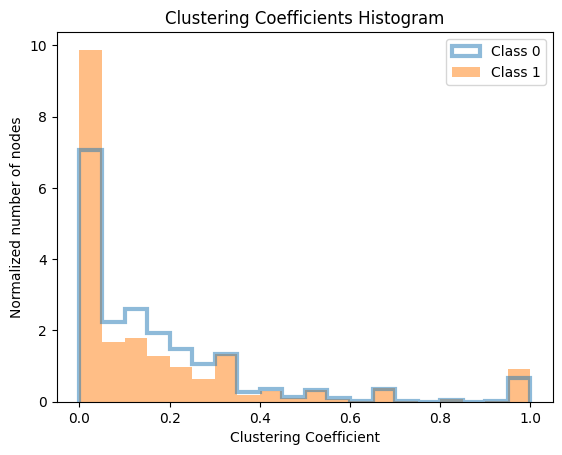

In [10]:
# Examine the clustering coefficients for each class
label_coefficient_dict = {label: get_clustering_coefficient(label, clustering_coefficients) for label in unique_labels}
evaluate_clustering_coefficients(label_coefficient_dict, 0.1)

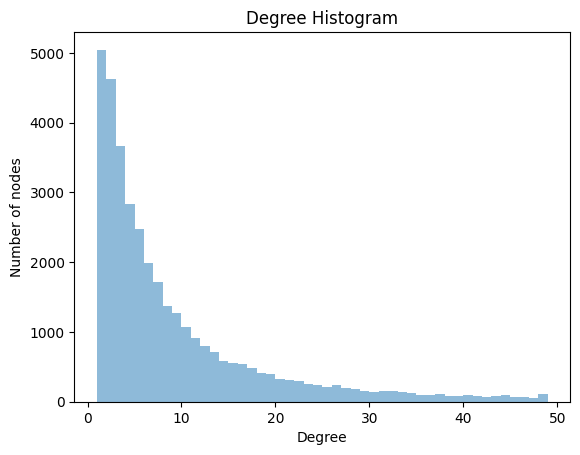

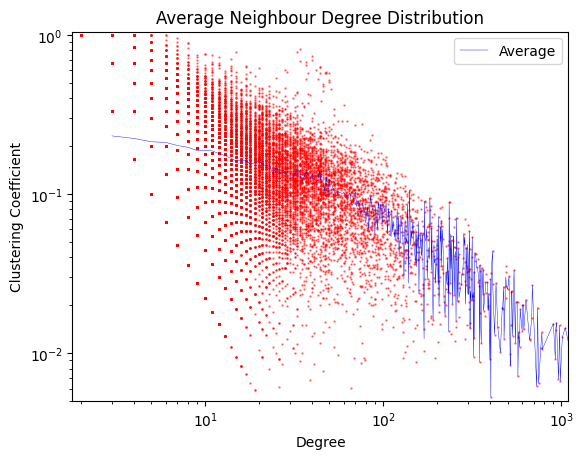

In [11]:
# Visualize the degree distribution to study the connectivity patterns
plt.figure()
plt.hist(degrees_all, bins=range(1, 50), alpha = 0.5)
plt.title("Degree Histogram")
plt.ylabel("Number of nodes")
plt.xlabel("Degree")
plt.show()

# Find the relations between clustering coefficients and degrees for the whole graph
unique_degrees = np.unique(degrees_all)
display_degrees = unique_degrees[unique_degrees >= 3]
mean_coefficients = [np.mean([clustering_coefficients_all[i] for i in range(len(degrees_all)) if degrees_all[i] == deg]) for deg in unique_degrees]
display_coefficients = [mean_coefficients[i] for i, degree in enumerate(unique_degrees) if degree in display_degrees]

plt.scatter(degrees_all, clustering_coefficients_all, color="red", alpha=0.5, s=0.5)
plt.plot(display_degrees, display_coefficients, color="blue", linestyle="-", linewidth=0.3, label='Average')
plt.title("Average Neighbour Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Clustering Coefficient")
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1.8)
plt.xlim(right=1100)
plt.ylim(bottom=0.005)
plt.ylim(top=1.05)
plt.legend()
plt.show()

### Local Clustering Coefficients
Clustering coefficients tell if the neighbours of a node are also connected to each other. It is the most local indicator of density: a lower clustering coefficient implies that the node is less likely to be in a (local neighbourhood) group.  

Both classes of this dataset exhibit a moderate clustering average, but it is evident that machine learning developers tend to cluster less than web developers.

### Degrees
The degree of a node is the count of how many links it has to other nodes.

In the GitHub dataset, the number of nodes having a specific degree follow an exponentially decreasing trend, indicating a **scale free network**.

While most nodes in the network have a relatively limited number of edges, a smaller subset of nodes (usually called *hubs*) exhibit an important network of connections. Some of the developers in the GitHub dataset are therefore acting as hubs of connections.

### Local Clustering Coefficients vs Degrees
The average neighbour degree distribution links two of their fundamental parameters: the clustering coefficients and the degrees.

Plotting it for the GitHub dataset highlights how, in this dataset, nodes with lower degree tend to have a higher clustering coefficient. Developers with many connections will connect to developers that are more likely to not interact with each other; the less connected nodes instead are more likely to connect to nodes that share edges between themselves (higher _clustering_ behaviour).

In [12]:
#++++++++++++++++++++++++++++++
# PyTorch Geometric tensors
#++++++++++++++++++++++++++++++

data = from_networkx(graph)   # ~2 min on Colab GPU
data.y = torch.tensor([node_labels[node] for node in graph.nodes()])  # Tensor containing the ground truths labels

# Input of the model will be the feature tensor
data.x = torch.zeros(num_nodes, max_feature + 1) # data.x = torch.eye(data.num_nodes)
for node in range(num_nodes):
    data.x[node] = torch.tensor(encoded_features_dict[str(node)])

## **PyTorch Geometric**

After the dataset preprocessing & examination, machine learning starts. The library adopted by this project is PyTorch Geometric, a state-of-the-art framework for graph neural networks.

The graph has to be converted to a suitable type for the library: `torch_geometric.data` describing a homogeneous graph.

### Features and Message Passing

In Pytorch Geometric, the  `data.x` are the input tensors of the neural network, i.e. the ***features*** of each node, while the `data.y` are the ground truth lables, i.e. the classes that the model will consider as ***prediction targets***.

In a GNN, the features are processed non-linearly via the **message passing** mechanism, which incorporate information from the edges (and/or) the adjacent nodes (more specifically: with a *k* number of layers, the *k*-adjacent nodes will be the nodes separated by a degree *k*).

In [13]:
#++++++++++++++++++++++++++++++
# 3-Fold data splitting
#++++++++++++++++++++++++++++++

# Data shuffling & splitting into three sets (60% training, 20% validation, 20% test)
indices = torch.arange(data.num_nodes) # Array of indices
train_indices, temp_indices = train_test_split(indices, train_size=0.6, shuffle=True, random_state=30)
val_indices, test_indices = train_test_split(temp_indices, train_size=0.5, shuffle=True, random_state=30) # Of the remaining indices, half is for validation and the other half is for testing

# Create boolean masks (only the mask indices are set to True)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = 1
data.val_mask[val_indices] = 1
data.test_mask[test_indices] = 1

# Dictionary to store the masks, useful for the metrics in the evaluation phase
masks = {'Training': data.train_mask, 'Testing': data.test_mask, 'Validation': data.val_mask}
masks_testing = {key: value for key, value in masks.items() if key != 'Validation'}

### A 3-Fold Splitting

In this code, the network hyperparameters are fine-tuned with respect to the *validation set*, while the final model's performance as a classifier is evaluated with respect to the *testing set*.

In [14]:
#++++++++++++++++++++++++++++++
# The model class
#++++++++++++++++++++++++++++++

class GATNet(torch.nn.Module):
    def __init__(self):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(data.num_node_features, 32, heads=2)  # 2 attention heads
        self.conv2 = GATConv(32*2, 16, heads=2)                    # 2 attention heads
        self.conv3 = GATConv(16*2, 2, heads=1)                     # 1 attention head

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.silu(x)
        x = F.dropout(x, p=0.2)
        x = self.conv2(x, edge_index)
        x = F.silu(x)
        x = F.dropout(x, p=0.2)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)


## **A Graph Attention Network**

While a general Graph Neural Network processes graph-structured data, a *Graph Attention Network* does so through the **attention mechanism**.

This model is composed of 3 attention-based layers with a varying numbers of attention heads, which are **indipendent** ways of aggregating information between nodes during the message passing. During training the layers learn to optimize how much "importance" each node gives to neighboring nodes, fine-tuning the attention weights. More heads means that the model is examining different aspects of the neighborhood at the same time. More layers means that the influence of more distant (_k_-adjacent) nodes is being examined.

As previously stated, the input of the model are the nodes features, which get processed through message passing.

Between the attention mechanism layers, non-linearity is introduced via Sigmoid Linear Unit (SiLU) activation function, and a dropout is applied to prevent overfitting.

The classifier output is finally produced with a (log) SoftMax function.

In [15]:
#++++++++++++++++++++++++++++++
# Instantiating the GNN
#++++++++++++++++++++++++++++++

model = GATNet()

Epoch: 1/60, Training Loss: 0.6931, Validation Loss: 0.6495
Epoch: 2/60, Training Loss: 0.6501, Validation Loss: 0.5956
Epoch: 3/60, Training Loss: 0.5918, Validation Loss: 0.5230
Epoch: 4/60, Training Loss: 0.5232, Validation Loss: 0.4604
Epoch: 5/60, Training Loss: 0.4535, Validation Loss: 0.4493
Epoch: 6/60, Training Loss: 0.4376, Validation Loss: 0.4910
Epoch: 7/60, Training Loss: 0.4804, Validation Loss: 0.4786
Epoch: 8/60, Training Loss: 0.4604, Validation Loss: 0.4595
Epoch: 9/60, Training Loss: 0.4425, Validation Loss: 0.4373
Epoch: 10/60, Training Loss: 0.4200, Validation Loss: 0.4289
Epoch: 11/60, Training Loss: 0.4163, Validation Loss: 0.4216
Epoch: 12/60, Training Loss: 0.4080, Validation Loss: 0.4327
Epoch: 13/60, Training Loss: 0.4192, Validation Loss: 0.4287
Epoch: 14/60, Training Loss: 0.4146, Validation Loss: 0.4281
Epoch: 15/60, Training Loss: 0.4152, Validation Loss: 0.4281
Epoch: 16/60, Training Loss: 0.4145, Validation Loss: 0.4186
Epoch: 17/60, Training Loss: 0.40

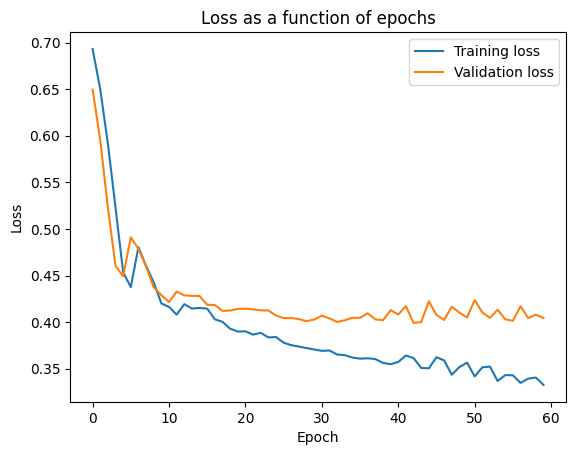

Best validation loss occoured at epoch: 43


In [16]:
#++++++++++++++++++++++++++++++
# Training
#++++++++++++++++++++++++++++++

n_epochs = 60

# Weights: necessary for class imbalance
weights = torch.tensor([1.0, 2.871])

# Lists to store losses. 3-fold approach: the model with the best validation loss will be chosen, and afterwards will be evaluated on the testing set
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Gradient descent algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()   # Necessary in Pytorch as it accumulates the gradient
    out = model(data)

    # Training loss needed for the parameters update
    train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=weights) # nll_loss since softmax is log
    train_losses.append(train_loss.item())

    # Backpropagation & parameters update, only considering the information coming from training set
    train_loss.backward()
    optimizer.step()

    # Calculating validation loss
    model.eval() # Necessary in Pytorch to disable dropout
    with torch.no_grad():  # Necessary in Pytorch to disable gradient computation
        val_out = model(data)
        val_loss = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask], weight=weights)
        val_losses.append(val_loss.item())

    # Logging of losses
    print(f"Epoch: {epoch + 1}/{n_epochs}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    # Saving the model when validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), f'best_model_params.pth')

    model.train()

# Plotting the losses as a function of epochs
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss as a function of epochs')
plt.legend()
plt.show()
print(f"Best validation loss occoured at epoch: {best_epoch}")

## **Training the GAT Model**

The Graph Attention Network is trained with PyTorch Geometric.

### Setup

- **Epochs:** 60.
- **Class Weights:** necessary due to the class inbalance; a total of 27961 nodes are labelled by "0", and 9739 by "1", meaning a 2.871:1 ratio in the set.
- **3-Fold Approach**: the parameters that are chosen for the model are those that minimize the loss on the validation set; their performance will be evaluated on the testing set.
- **Optimizer:** Adam algorithm, with a learning rate of 0.01 and weight decay of 5e-4, is used for gradient descent.

### Training Loop


1. **Forward Pass** predicts the class labels.
2. **Loss** for the training data is calculated with **negative log-likelihood** (due to the log-SoftMax), considering class weights to address imbalances.
3. **Backward Pass** computes gradients via backpropagation for the training set.
4. **Parameters Update** by Adam optimizer, based on the computed gradients.
5. **Validation** loss is calculated after the model is switched to evaluation mode.
6. **Logging** of training and validation losses.
7. **Saving of Parameters** of the best performing model with respect to the validation set.

In [17]:
#++++++++++++++++++++++++++++++
# Evaluation
#++++++++++++++++++++++++++++++

# Loading the model with lowest validation loss
best_model = GATNet()
best_model.load_state_dict(torch.load('best_model_params.pth'))

# Evaluating the best model & extracting the arrays for the metrics: true classes, predicted classes, probabilities of Class 1
best_model.eval()
with torch.no_grad():
  output = best_model(data)
  probs, pred = output.max(dim=1)

y_true = data.y.cpu().detach().numpy()            # True classes
y_pred = pred.cpu().detach().numpy()              # Predicted classes

softmax_output = F.softmax(output, dim=1)  # Convert the log to probabilities
out_probs = softmax_output[:, 1].cpu().detach().numpy() # Probabilities of Class 1
#out_probs = output[:, 1].cpu().detach().numpy()   # Probabilities of Class 1 (when final activation function is not log)

print("Output:")
print(output)
print("\nTrue classes - Predicted classes - Probabilities of Class 1:")
print(y_true)
print(y_pred)
print(out_probs)

Output:
tensor([[-0.2024, -1.6968],
        [-0.1414, -2.0260],
        [-1.4241, -0.2754],
        ...,
        [-0.0312, -3.4829],
        [-2.0895, -0.1321],
        [-0.0503, -3.0146]])

True classes - Predicted classes - Probabilities of Class 1:
[0 0 1 ... 0 1 0]
[0 0 1 ... 0 1 0]
[0.18326293 0.13185774 0.7592768  ... 0.03071861 0.87625206 0.04906502]


In [18]:
#++++++++++++++++++++++++++++++
# Performance metrics
#++++++++++++++++++++++++++++++

# Accuracy
correct = float((y_true[data.test_mask] == y_pred[data.test_mask]).sum())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.3f}'.format(acc))

# Precision, recall, f1 score - weighted according to class
precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='weighted')
recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='weighted')
f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='weighted')

print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))

Accuracy: 0.830
Precision: 0.856
Recall: 0.830
F1 Score: 0.836


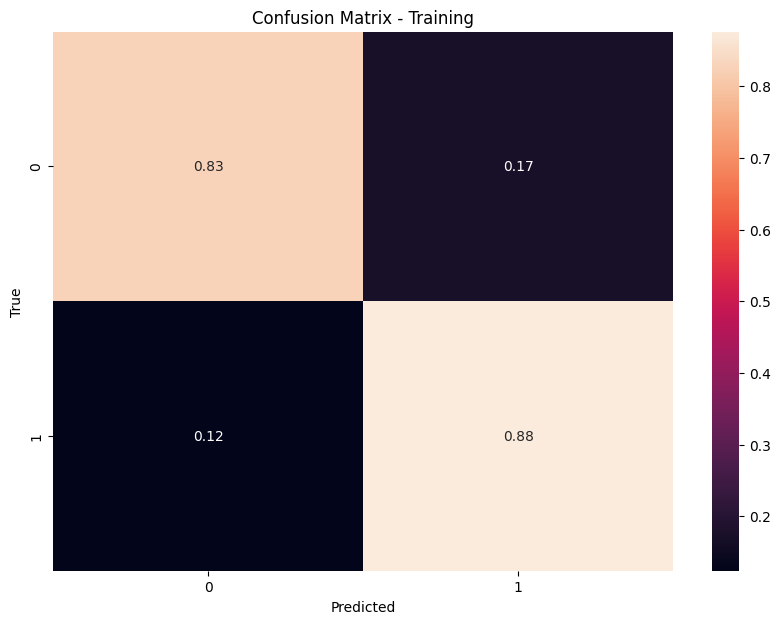

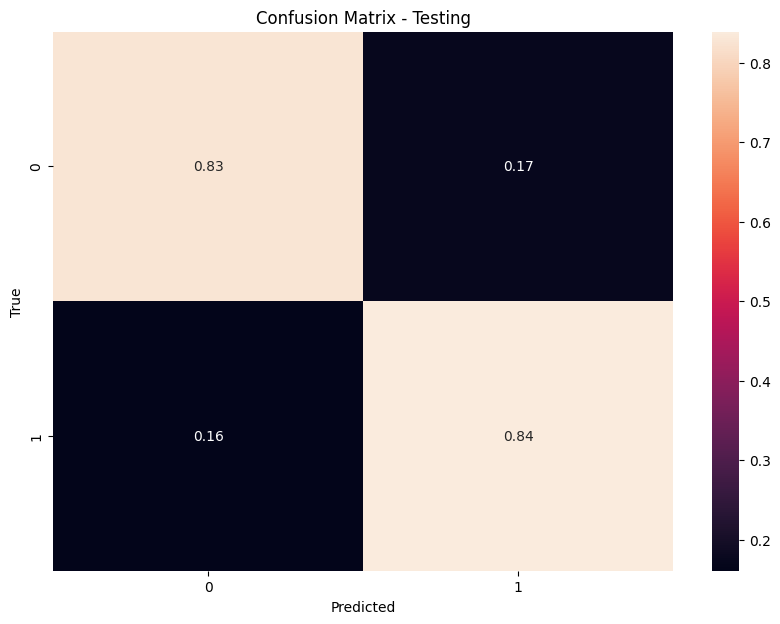

In [19]:
#++++++++++++++++++++++++++++++
# Normalized Confusion Matrix
#++++++++++++++++++++++++++++++

# Class weights
weights = np.array([1.0, 2.871])

for dataset_name, mask in masks_testing.items():
    cm = confusion_matrix(y_true[mask], y_pred[mask])
    cm = cm * weights[:, np.newaxis]

    # Normalize the weighted confusion matrices by class
    cm = cm / cm.sum(axis=1)[:, np.newaxis]

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.show()

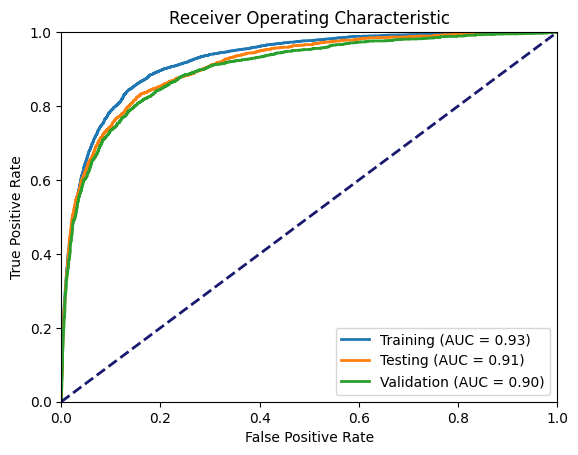

In [20]:
#++++++++++++++++++++++++++++++
# ROC curve and AUC
#++++++++++++++++++++++++++++++

plt.figure()
for dataset_name, mask in masks.items():
    fpr, tpr, _ = roc_curve(y_true[mask], out_probs[mask])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{dataset_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='midnightblue', lw=2, linestyle='--') # Reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


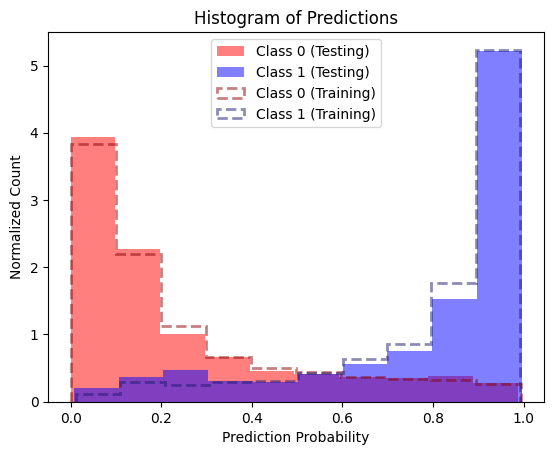

In [21]:
#++++++++++++++++++++++++++++++
# Histogram of Output Scores
#++++++++++++++++++++++++++++++

# Separation of the output probabilities based on the ground truth labels
out_probs_train_0 = out_probs[data.train_mask][y_true[data.train_mask] == 0]
out_probs_train_1 = out_probs[data.train_mask][y_true[data.train_mask] == 1]
out_probs_test_0 = out_probs[data.test_mask][y_true[data.test_mask] == 0]
out_probs_test_1 = out_probs[data.test_mask][y_true[data.test_mask] == 1]

# Plotting
plt.figure()
plt.hist(out_probs_test_0, bins=10, alpha=0.5, label='Class 0 (Testing)', weights=[1]*len(out_probs_test_0), density=True, color='red')
plt.hist(out_probs_test_1, bins=10, alpha=0.5, label='Class 1 (Testing)', weights=[2.871]*len(out_probs_test_1), density=True, color='blue')
plt.hist(out_probs_train_0, bins=10, alpha=0.5, label='Class 0 (Training)', weights=[1]*len(out_probs_train_0), density=True, color='darkred', histtype='step', linewidth=2, linestyle="--")
plt.hist(out_probs_train_1, bins=10, alpha=0.5, label='Class 1 (Training)', weights=[2.871]*len(out_probs_train_1), density=True, color='midnightblue', histtype='step', linewidth=2, linestyle="--")
plt.title('Histogram of Predictions')
plt.xlabel('Prediction Probability')
plt.ylabel('Normalized Count')
plt.legend(loc='upper center')
plt.show()

### Results

The model has successfully learned to distinguish between the two classes, demonstrating a good ROC's AUC & scores, and no indications of overtraining.